In [44]:
import pandas as pd

# Load the aggregated data
aggregated_stats = pd.read_csv('daily_log_returns_yfinance.csv')
print("Loaded Aggregated Data:")
print(aggregated_stats.head())

Loaded Aggregated Data:
  Symbol                       Date  Close  LogReturn
0  MCJKF  2024-01-02 00:00:00+00:00    NaN        NaN
1  MCJKF  2024-01-03 00:00:00+00:00    NaN        NaN
2  MCJKF  2024-01-04 00:00:00+00:00    NaN        NaN
3  MCJKF  2024-01-05 00:00:00+00:00    NaN        NaN
4  MCJKF  2024-01-08 00:00:00+00:00    NaN        NaN


In [45]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('daily_log_returns_yfinance.csv')

# Step 1: Sample 10% of unique stock symbols
unique_symbols = data['Symbol'].unique()
sample_size = int(0.02 * len(unique_symbols))  # 10% of total unique symbols
sampled_symbols = np.random.choice(unique_symbols, size=sample_size, replace=False)

# Filter data for sampled symbols
sampled_data = data[data['Symbol'].isin(sampled_symbols)].copy()

# Step 2: Take data every two days for each stock
sampled_data['Date'] = pd.to_datetime(sampled_data['Date'])  # Ensure 'Date' is a datetime object

# Initialize an empty DataFrame to store the results
resampled_data = pd.DataFrame()

# Loop through each symbol and resample the data for every two days
for symbol in sampled_symbols:
    symbol_data = sampled_data[sampled_data['Symbol'] == symbol]
    symbol_data = symbol_data.set_index('Date').resample('2D').first().reset_index()
    symbol_data['Symbol'] = symbol  # Re-add the symbol column
    resampled_data = pd.concat([resampled_data, symbol_data])

# Save the resulting dataset to a new CSV file
resampled_data.to_csv('filtered_time_series_data.csv', index=False)

print("Data sampling complete. Saved to 'filtered_time_series_data.csv'")


Data sampling complete. Saved to 'filtered_time_series_data.csv'


In [46]:
import pandas as pd

# Load the dataset
data = pd.read_csv('filtered_time_series_data.csv')

# Check the size of the dataset
print("Dataset Shape (rows, columns):", data.shape)

# Check the number of unique symbols
unique_symbols = data['Symbol'].nunique()
print("Number of unique symbols:", unique_symbols)


Dataset Shape (rows, columns): (8190, 4)
Number of unique symbols: 546


In [47]:
#not important because compromises volatility
import pandas as pd

# Load the original dataset
data = pd.read_csv('daily_log_returns_yfinance.csv')

# Filter out rows where LogReturn is 0 or NaN
filtered_data = data[(data['LogReturn'] != 0) & (data['LogReturn'].notna())]

# Save the filtered data to a new CSV file
filtered_data.to_csv('filtered_non_zero_log_returns.csv', index=False)

print("Filtered data saved to 'filtered_non_zero_log_returns.csv'")
print("Original dataset size:", data.shape)
print("Filtered dataset size:", filtered_data.shape)

unique_symbols = data['Symbol'].nunique()
print("Number of unique symbols:", unique_symbols)


Filtered data saved to 'filtered_non_zero_log_returns.csv'
Original dataset size: (546780, 4)
Filtered dataset size: (230867, 4)
Number of unique symbols: 27339


/Users/armaan_thakker/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/armaan_thakker/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


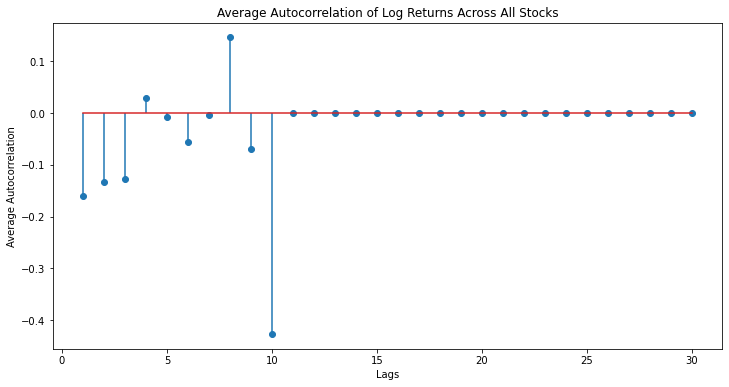

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the dataset
data = pd.read_csv('filtered_non_zero_time_series_data.csv')

# Set the maximum number of lags
max_lags = 30

# Initialize a dictionary to store autocorrelations for each lag across all stocks
autocorrelation_results = defaultdict(list)

# Loop through each unique stock symbol
for symbol in data['Symbol'].unique():
    stock_data = data[data['Symbol'] == symbol]
    log_returns = stock_data['LogReturn'].dropna()  # Drop NaN values to avoid calculation issues

    # Calculate autocorrelation for each lag up to max_lags
    for lag in range(1, max_lags + 1):
        if len(log_returns) > lag:
            autocorr = log_returns.autocorr(lag=lag)  # Calculate autocorrelation at each lag
            if not pd.isna(autocorr):  # Ignore NaN values
                autocorrelation_results[lag].append(autocorr)

# Ensure each lag up to max_lags has an entry in average_autocorrelations
average_autocorrelations = {
    lag: (sum(autocorrelation_results.get(lag, [])) / len(autocorrelation_results.get(lag, []))
          if len(autocorrelation_results.get(lag, [])) > 0 else 0)
    for lag in range(1, max_lags + 1)
}

# Plot the average autocorrelation across all stocks
plt.figure(figsize=(12, 6))
plt.stem(range(1, max_lags + 1), list(average_autocorrelations.values()), use_line_collection=True)
plt.xlabel('Lags')
plt.ylabel('Average Autocorrelation')
plt.title('Average Autocorrelation of Log Returns Across All Stocks')
plt.show()


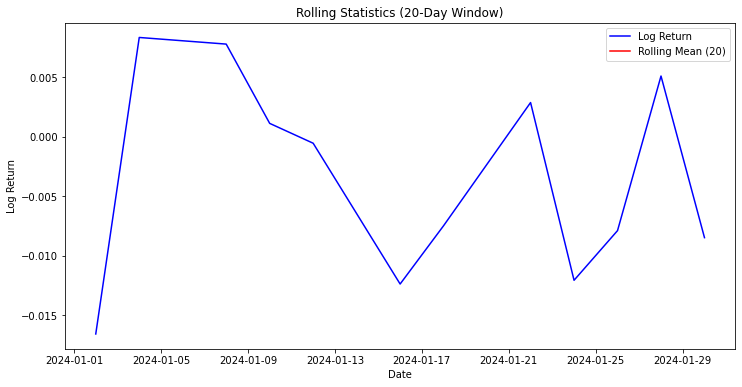

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define rolling statistics function for a numeric series
def rolling_statistics(series, window=20):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    # Convert indices and values to numpy arrays to avoid multi-dimensional indexing issues
    dates = series.index.to_numpy()
    log_returns = series.to_numpy()
    mean_values = rolling_mean.to_numpy()
    lower_bound = (rolling_mean - rolling_std).to_numpy()
    upper_bound = (rolling_mean + rolling_std).to_numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates, log_returns, label="Log Return", color="blue")
    plt.plot(dates, mean_values, label="Rolling Mean (20)", color="red")
    plt.fill_between(dates, lower_bound, upper_bound, color="gray", alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.title("Rolling Statistics (20-Day Window)")
    plt.show()

# Load the dataset
data = pd.read_csv('filtered_non_zero_time_series_data.csv')

# Ensure 'Date' column is parsed as datetime
data['Date'] = pd.to_datetime(data['Date'])

# Choose a single stock for demonstration (e.g., the first unique symbol)
symbol = data['Symbol'].unique()[0]
sample_stock_data = data[data['Symbol'] == symbol].set_index('Date')['LogReturn'].dropna()

# Call the rolling statistics function on the numeric series only
rolling_statistics(sample_stock_data)


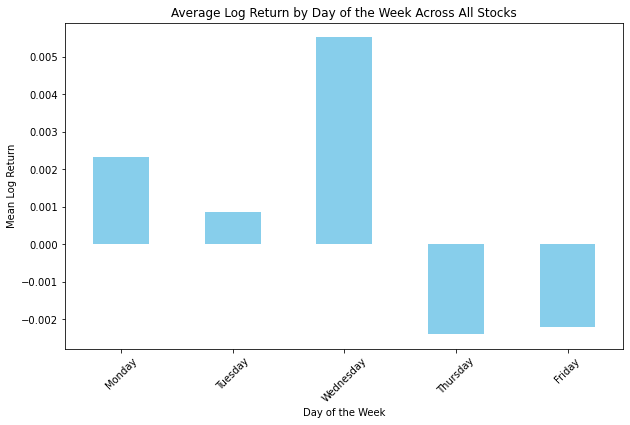

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('filtered_non_zero_time_series_data.csv')

# Ensure 'Date' is parsed as datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extract the day of the week
data['DayOfWeek'] = data['Date'].dt.day_name()

# Calculate the mean log return for each day of the week across all stocks
weekly_avg = data.groupby('DayOfWeek')['LogReturn'].mean()

# Order the days for a clear plot (Monday to Friday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekly_avg = weekly_avg.reindex(day_order)

# Plotting
plt.figure(figsize=(10, 6))
weekly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Log Return by Day of the Week Across All Stocks')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Log Return')
plt.xticks(rotation=45)
plt.show()


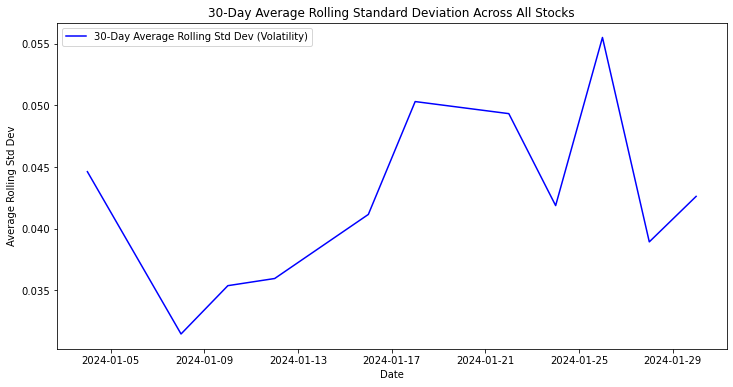

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('filtered_non_zero_time_series_data.csv')

# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Set the rolling window size
window = 30

# Step 1: Calculate the 30-day rolling standard deviation for each stock
data['RollingStd'] = data.groupby('Symbol')['LogReturn'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

# Step 2: Calculate the daily average of the rolling standard deviation across all stocks
average_rolling_std = data.groupby('Date')['RollingStd'].mean().dropna()

# Step 3: Convert the index and values to numpy arrays for plotting
dates = average_rolling_std.index.to_numpy()
rolling_std_values = average_rolling_std.values

# Plot the average rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(dates, rolling_std_values, label=f'{window}-Day Average Rolling Std Dev (Volatility)', color='blue')
plt.xlabel('Date')
plt.ylabel('Average Rolling Std Dev')
plt.title(f'{window}-Day Average Rolling Standard Deviation Across All Stocks')
plt.legend()
plt.show()
